### Import Dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


In [2]:
default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)
forcing_namelist = list(default_params.columns)

param_categories = {}
param_categories['other_wmghgs'] = ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8','carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methyl_bromide', 'methyl_chloride', 'nf3', 'sf6', 'so2f2', 'halon1202']
param_categories['carbon_dioxide'] = ['carbon_dioxide']
param_categories['methane'] = ['methane']
param_categories['nitrous_oxide'] = ['nitrous_oxide']
param_categories['trop_o3'] = [x for x in forcing_namelist if '|trop_o3' in x]
param_categories['strat_o3'] = [x for x in forcing_namelist if '|strat_o3' in x]
param_categories['strat_h2o'] = [x for x in forcing_namelist if '|strat_h2o' in x]
param_categories['ari'] = ['so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3','oc','nox_avi']
param_categories['aci'] = ['so2|aci','oc|aci','bc|aci']
param_categories['aer'] = param_categories['aci'] + param_categories['ari']
param_categories['bc_on_snow'] = ['bc|bc_on_snow']
param_categories['contrails'] = ['nox_avi|contrails']

## Import datasets

In [3]:
# MAGICC7.1.0.beta RCMIP runs
magicc_scm = pd.read_csv('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/magicc7/rcmip_phase-1_magicc7.1.0.beta_v1-0-0.csv').set_index(['Region','Scenario','Variable'])
magicc_scm.iloc[:,3:] = magicc_scm.iloc[:,3:].apply(pd.to_numeric)
magicc_scm.columns = list(magicc_scm.columns)[:3] + [int(x) for x in list(magicc_scm.columns)[3:]]

In [4]:
fair_scm = pd.concat([pd.read_csv(x) for x in glob.glob('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/fair/*default*v1-0-1*')]).set_index(['Region','Scenario','Variable'])
fair_scm.iloc[:,3:] = fair_scm.iloc[:,3:].apply(pd.to_numeric)
fair_scm.columns = list(fair_scm.columns)[:3] + [int(x.split('-')[0]) for x in fair_scm.columns[3:]]

In [5]:
## switch in GCP co2 emissions up to start of SSPs
GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# set 1750 value to 0
GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# linearly interpolate between 0 and first land-use-change datapoint
GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

In [6]:
## NEED TO CHECK THIS AND ENSURE CONSISTENT RESULTS WITH full NROY

def run_NROY_ssp(ssp,param_sets=[0]):

    ssp_emms = RCMIP_to_GIR_input_emms(ssp).interpolate().reindex(np.arange(1750,2151))
    ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values
    sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,'carbon_dioxide']
    ssp_emms.loc[:2014,'carbon_dioxide'] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
    ssp_emms.loc[2015:2025,'carbon_dioxide'] *= np.linspace(sf,1,11)

    ALL_output = []

    gas_param_ensemble = []
    thermal_param_ensemble = []
    EXT_forc_sfs = []

    basedir = '../Parameter_Sets/NROY/'

    for param_set_start in param_sets:

        gas_param_file,response_param_file,level_constraint_file,rate_constrain_file,ext_forc_file = [basedir+x+'_mem'+str(param_set_start)+'-mem'+str(param_set_start+9999)+'_v1.pkl' for x in ['gas_params','response_params','temp_constraint','rate_constraint','EXT_forc']]
        level_constraint = pd.read_pickle(level_constraint_file)
        rate_constraint = pd.read_pickle(rate_constrain_file)
        full_constraint = level_constraint & rate_constraint
        NROY_mems = [x[0] for x in full_constraint[full_constraint].index]
        gas_param_ensemble += [pd.read_pickle(gas_param_file).reindex(NROY_mems,axis=1,level=0)]
        thermal_param_ensemble += [pd.read_pickle(response_param_file).reindex(NROY_mems,axis=1,level=0)]
        EXT_forc_sfs += [pd.read_pickle(ext_forc_file).reindex(NROY_mems,axis=1)]

    thermal_param_ensemble = pd.concat(thermal_param_ensemble,axis=1)
    gas_param_ensemble = pd.concat(gas_param_ensemble,axis=1)
    EXT_forc_sfs = pd.concat(EXT_forc_sfs,axis=1)

    mem_names = gas_param_ensemble.columns.levels[0]
    N = gas_param_ensemble.columns.levels[0].size

    erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float)
    
    ## LUC
    LUC_forc_ensemble = pd.concat([erf_ar6['land_use'].reindex(np.arange(1750,2151))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['LUC']

    ## Natural
    volc_forc_ensemble = pd.concat([erf_ar6['volcanic'].reindex(np.arange(1750,2151))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['volc']
    sol_forc_ensemble = pd.concat([erf_ar6['solar'].reindex(np.arange(1750,2151))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['sol']

    ssp_forc = pd.concat([LUC_forc_ensemble+volc_forc_ensemble+sol_forc_ensemble],axis=1,keys=['forcing']).swaplevel(0,1,axis=1)

    ssp_emms_run = pd.concat([ssp_emms]*N,axis=1,keys=gas_param_ensemble.columns.levels[0])

    results = run_GIR(emissions_in=ssp_emms_run,forcing_in=ssp_forc,gas_parameters=gas_param_ensemble,thermal_parameters=thermal_param_ensemble)

    return results['RF'],results['T'],LUC_forc_ensemble

In [7]:
FULL_probabilities = pd.read_hdf('../Parameter_Sets/NROY_GWI_informed/FULL_member_selection_probabilities.h5')
GWI_constraint = FULL_probabilities>np.random.random(FULL_probabilities.size)

In [8]:
def get_GWI_ensemble_parameters(ensemble_size=10000):

    gas_param_ensemble = []
    thermal_param_ensemble = []
    EXT_forc_sfs = []

    gas_param_files = sorted(glob.glob('../Parameter_Sets/NROY_GWI_informed/gas_params*'))
    response_param_files = sorted(glob.glob('../Parameter_Sets/NROY_GWI_informed/response_params*'))
    EXT_forc_files = sorted(glob.glob('../Parameter_Sets/NROY_GWI_informed/EXT_forc*'))

    mems_selected=0
    i=0

    while mems_selected <= ensemble_size:

        unconstrained_data = pd.read_pickle(gas_param_files[i])
        mems_constraint = GWI_constraint.reindex(unconstrained_data.columns.levels[0]).replace(False,np.nan).dropna().index
        gas_param_ensemble += [unconstrained_data.reindex(mems_constraint,axis=1,level=0)]
        unconstrained_data = pd.read_pickle(response_param_files[i])
        thermal_param_ensemble += [unconstrained_data.reindex(mems_constraint,axis=1,level=0)]
        unconstrained_data = pd.read_pickle(EXT_forc_files[i])
        EXT_forc_sfs += [unconstrained_data.reindex(mems_constraint,axis=1)]

        mems_selected += mems_constraint.size

        i+=1

    thermal_param_ensemble = pd.concat(thermal_param_ensemble,axis=1)
    gas_param_ensemble = pd.concat(gas_param_ensemble,axis=1)
    EXT_forc_sfs = pd.concat(EXT_forc_sfs,axis=1)
    
    return gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs

In [9]:
def run_GWI_NROY_ssp(ssp,gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs):

    ssp_emms = RCMIP_to_GIR_input_emms(ssp).interpolate().reindex(np.arange(1750,2151))
    ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values
    sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,'carbon_dioxide']
    ssp_emms.loc[:2014,'carbon_dioxide'] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
    ssp_emms.loc[2015:2025,'carbon_dioxide'] *= np.linspace(sf,1,11)

    mem_names = gas_param_ensemble.columns.levels[0]
    N = gas_param_ensemble.columns.levels[0].size

    erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float)
    
    ## LUC
    LUC_forc_ensemble = pd.concat([erf_ar6['land_use'].reindex(np.arange(1750,2151))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['LUC']

    ## Natural
    volc_forc_ensemble = pd.concat([erf_ar6['volcanic'].reindex(np.arange(1750,2151))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['volc']
    sol_forc_ensemble = pd.concat([erf_ar6['solar'].reindex(np.arange(1750,2151))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['sol']

    ssp_forc = pd.concat([LUC_forc_ensemble+volc_forc_ensemble+sol_forc_ensemble],axis=1,keys=['forcing']).swaplevel(0,1,axis=1)

    ssp_emms_run = pd.concat([ssp_emms]*N,axis=1,keys=gas_param_ensemble.columns.levels[0])

    results = run_GIR(emissions_in=ssp_emms_run,forcing_in=ssp_forc,gas_parameters=gas_param_ensemble,thermal_parameters=thermal_param_ensemble)

    return results['RF'],results['T'],LUC_forc_ensemble

In [10]:
scenarios = ['ssp'+x for x in ['119','126','245','370','585']]
# scenarios = [x for x in magicc_scm.index.levels[1] if 'ssp' in x and x[0]!='e']

plot_results = pd.DataFrame(index = np.arange(1750,2151),columns=pd.MultiIndex.from_product([scenarios,list(param_categories.keys()) + ['anthro','temp'],[5,16.6,50,83.3,95]]))

gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs = get_GWI_ensemble_parameters(ensemble_size=15000)

for ssp in scenarios:
    
    print('computing '+ssp+' projection')
    results_rf,results_T,LUC_forc = run_GWI_NROY_ssp(ssp,gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs)
    
    for forc_cat in param_categories.keys():
        for quantile in [5,16.6,50,83.3,95]:
            plot_results.loc[:,(ssp,forc_cat,quantile)] = results_rf.loc[:,(slice(None),param_categories[forc_cat])].groupby(level=0,axis=1).sum().quantile(quantile/100,axis=1)
            
    for quantile in [5,16.6,50,83.3,95]:
        plot_results.loc[:,(ssp,'anthro',quantile)] = (results_rf.xs('Total',axis=1,level=1) - results_rf.xs('External',axis=1,level=1) + LUC_forc).quantile(quantile/100,axis=1)
        plot_results.loc[:,(ssp,'temp',quantile)] = (results_T - results_T.loc[1861:1880].mean()).quantile(quantile/100,axis=1)

computing ssp119 projection
Integrating 15228 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'me

100%|██████████| 400/400 [00:45<00:00,  8.76 timestep/s]


computing ssp126 projection
Integrating 15228 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'me

100%|██████████| 400/400 [00:45<00:00,  8.74 timestep/s]


computing ssp245 projection
Integrating 15228 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'me

100%|██████████| 400/400 [00:45<00:00,  8.77 timestep/s]


computing ssp370 projection
Integrating 15228 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'me

100%|██████████| 400/400 [00:46<00:00,  8.60 timestep/s]


computing ssp585 projection
Integrating 15228 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'me

100%|██████████| 400/400 [00:44<00:00,  8.92 timestep/s]


In [11]:
## reconfigure to have total anthro ERF LARGE in top left and others 1/2 size around

In [12]:
magicc_erf_cats = ['Effective Radiative Forcing|Anthropogenic|CO2',
                   'Effective Radiative Forcing|Anthropogenic|CH4',
                   'Effective Radiative Forcing|Anthropogenic|N2O',
                   'Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone',
                   'Effective Radiative Forcing|Anthropogenic|Stratospheric Ozone',
                   'Effective Radiative Forcing|Anthropogenic|Other|CH4 Oxidation Stratospheric H2O',
                   'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions',
                   'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions',
                   'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow',
                  ]

## F-Gases / Montreal Gases

magicc_data = pd.DataFrame(index=np.arange(1850,2101),columns=pd.MultiIndex.from_product([scenarios,param_categories.keys()]))
for ssp in scenarios:
    for i,forc_cat in enumerate(list(param_categories.keys())[1:-3]+['bc_on_snow']):
        magicc_data.loc[:,(ssp,forc_cat)] = magicc_scm.loc[('World','esm-'+ssp+'-allGHG',magicc_erf_cats[i]),range(1850,2101)].values
        
    magicc_data.loc[:,(ssp,'aer')] = magicc_data.loc[:,(ssp,'ari')]+magicc_data.loc[:,(ssp,'aci')]
    magicc_data.loc[:,(ssp,'other_wmghgs')] = magicc_scm.loc[('World','esm-'+ssp+'-allGHG',[x for x in magicc_scm.index.levels[2] if 'Effective' in x and (('F-Gases' in x) or ('Montreal' in x))]),range(1850,2101)].groupby(level=1).sum().values.flatten()
    magicc_data.loc[:,(ssp,'anthro')] = magicc_scm.loc[('World','esm-'+ssp+'-allGHG','Effective Radiative Forcing|Anthropogenic'),range(1850,2101)].values
    

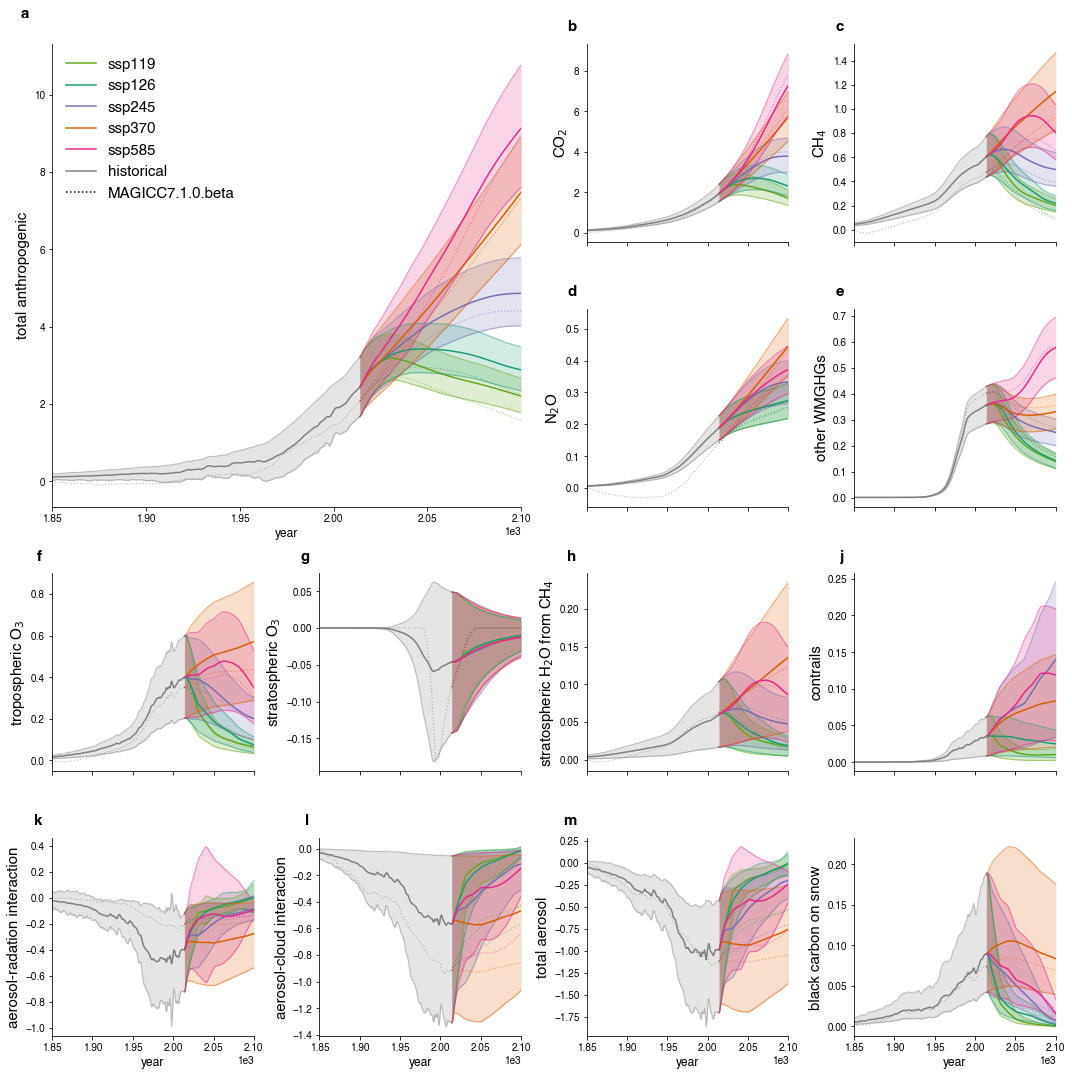

In [13]:
fig=plt.figure(figsize=(15,15))

map_forc_cat = dict(zip(param_categories.keys(),['other WMGHGs','CO$_2$','CH$_4$','N$_2$O','tropospheric O$_3$','stratospheric O$_3$','stratospheric H$_2$O from CH$_4$','aerosol-radation interaction','aerosol-cloud interaction','total aerosol','black carbon on snow','contrails']))
forc_cat_order = ['carbon_dioxide', 'methane', 'nitrous_oxide','other_wmghgs','trop_o3', 'strat_o3', 'strat_h2o','contrails','ari', 'aci', 'aer','bc_on_snow']

gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[:2,:2])
ax2 = [fig.add_subplot(gs[i,j]) for i in np.arange(4) for j in np.arange(4) if (i>=2) or (j>=2)]
colors= {'ssp245':'#7570b3','ssp370':'#d95f02','ssp585':'#e7298a','ssp119':'#66a61e','ssp126':'#1b9e77','history':'grey'}
for ssp in scenarios:
    ax1.plot(plot_results.loc[2014:2100,(ssp,'anthro',50)],color=colors[ssp],label=ssp)
    ax1.fill_between(plot_results.loc[2014:2100].index,*plot_results.loc[2014:2100,(ssp,'anthro',[5,95])].values.T,color=colors[ssp],lw=0,alpha=0.2)
    ax1.plot(plot_results.loc[2014:2100].index,plot_results.loc[2014:2100,(ssp,'anthro',[5,95])],color=colors[ssp],lw=1.2,alpha=0.5)
    
    ax1.plot(magicc_data.loc[2014:2100].index,magicc_data.loc[2014:2100,(ssp,'anthro')],color=colors[ssp],ls=':',lw=1.2,alpha=0.5)
    
    for i,forc_cat in enumerate(forc_cat_order):
        ax2[i].plot(plot_results.loc[2014:2100,(ssp,forc_cat,50)],color=colors[ssp])
        ax2[i].fill_between(plot_results.loc[2014:2100].index,*plot_results.loc[2014:2100,(ssp,forc_cat,[5,95])].values.T,color=colors[ssp],lw=0,alpha=0.2)
        ax2[i].plot(plot_results.loc[2014:2100].index,plot_results.loc[2014:2100,(ssp,forc_cat,[5,95])],color=colors[ssp],lw=1.2,alpha=0.5)
        
        ax2[i].plot(magicc_data.loc[2014:2100].index,magicc_data.loc[2014:2100,(ssp,forc_cat)],color=colors[ssp],ls=':',lw=1.2,alpha=0.5)
        
ax1.plot(plot_results.loc[:2014,(ssp,'anthro',50)],color=colors['history'],label='historical')
ax1.fill_between(plot_results.loc[:2014].index,*plot_results.loc[:2014,(ssp,'anthro',[5,95])].values.T,color=colors['history'],lw=0,alpha=0.2)
ax1.plot(plot_results.loc[:2014].index,plot_results.loc[:2014,(ssp,'anthro',[5,95])],color=colors['history'],lw=1.2,alpha=0.5)

ax1.plot(magicc_data.loc[:2014].index,magicc_data.loc[:2014,(ssp,'anthro')],color=colors['history'],ls=':',lw=1.2,alpha=0.5)

for i,forc_cat in enumerate(forc_cat_order):
        ax2[i].plot(plot_results.loc[:2014,(ssp,forc_cat,50)],color=colors['history'])
        ax2[i].fill_between(plot_results.loc[:2014].index,*plot_results.loc[:2014,(ssp,forc_cat,[5,95])].values.T,color=colors['history'],lw=0,alpha=0.2)
        ax2[i].plot(plot_results.loc[:2014].index,plot_results.loc[:2014,(ssp,forc_cat,[5,95])],color=colors['history'],lw=1.2,alpha=0.5)
        
        ax2[i].plot(magicc_data.loc[:2014].index,magicc_data.loc[:2014,(ssp,forc_cat)],color=colors['history'],ls=':',lw=1.2,alpha=0.5)
        
        ax2[i].set_ylabel(map_forc_cat[forc_cat],fontsize=15)

        
ax1.set_ylabel('total anthropogenic',fontsize=15)
[a.tick_params(labelbottom=False) for a in ax2[:-4]]
[a.set_xlabel('year',fontsize=12) for a in ax2[-4:]+[ax1]]
[a.spines[pos].set_visible(False) for a in ax2+[ax1] for pos in ['right','top']]
[a.set_xlim(1850,2100) for a in ax2+[ax1]]
[ax2[i].text(-0.05,1.05,x,va='bottom',ha='right',transform=ax2[i].transAxes,fontweight='bold',fontsize=15) for i,x in enumerate(['b','c','d','e','f','g','h','j','k','l','m'])]
ax1.text(-0.05,1.05,'a',va='bottom',ha='right',transform=ax1.transAxes,fontweight='bold',fontsize=15)
ax1.plot([],[],'k:',label='MAGICC7.1.0.beta')
ax1.legend(loc='upper left',fontsize=15)
plt.tight_layout()

# [fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/SSP_NROY_ERF_grid.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

In [3]:
## Import some temperature data
baseline = ['1850','1900']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
## get some CMIP6 model data

## get the actual historical / ssp data:
ssp_tas = pd.read_csv('../tools/cmip6_data/ssp_tas.csv',index_col=0)
hist_tas = pd.read_csv('../tools/cmip6_data/hist_tas.csv',index_col=0).iloc[1:]

for i,x in enumerate(['source','member','variable','experiment']):
    ssp_tas.loc[x] = [x.split('_')[i+1] for x in ssp_tas.columns]
for i,x in enumerate(['source','member']):    
    hist_tas.loc[x] = [x.split('_')[i+1] for x in hist_tas.columns]
    

ssp_tas=ssp_tas.T.set_index(['source','member','experiment']).T.drop('variable').apply(pd.to_numeric)
hist_tas=hist_tas.T.set_index(['source','member']).T.apply(pd.to_numeric)
ssp_tas['year']=[int(x) for x in ssp_tas.index]
ssp_tas = ssp_tas.set_index('year')
ssp_tas = ssp_tas.reindex(np.arange(1850,2301))

hist_tas['year']=[int(x) for x in hist_tas.index]
hist_tas = hist_tas.set_index('year')

for modmem in hist_tas.columns:
    if modmem in ssp_tas.columns.droplevel(-1):
        for exp in ssp_tas.loc[1850:2014,modmem].columns:
            ssp_tas.loc[1850:2014,(*modmem,exp)] = hist_tas.loc[1850:2014,modmem]
            
baseline = [1861,1880]

plot_cmip6_tas2100 = ssp_tas.drop(('KACE-1-0-G','r3i1p1f1'),axis=1).groupby(level=(0,2),axis=1).mean()
plot_cmip6_tas2100 = plot_cmip6_tas2100 - plot_cmip6_tas2100.loc[baseline[0]:baseline[1]].mean()

In [16]:
CMIP6_ssp_statistics = plot_cmip6_tas2100.loc[2081:2100].T.drop_duplicates().T.mean().groupby(level=1).describe(percentiles=[0.166,0.5,0.833])

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


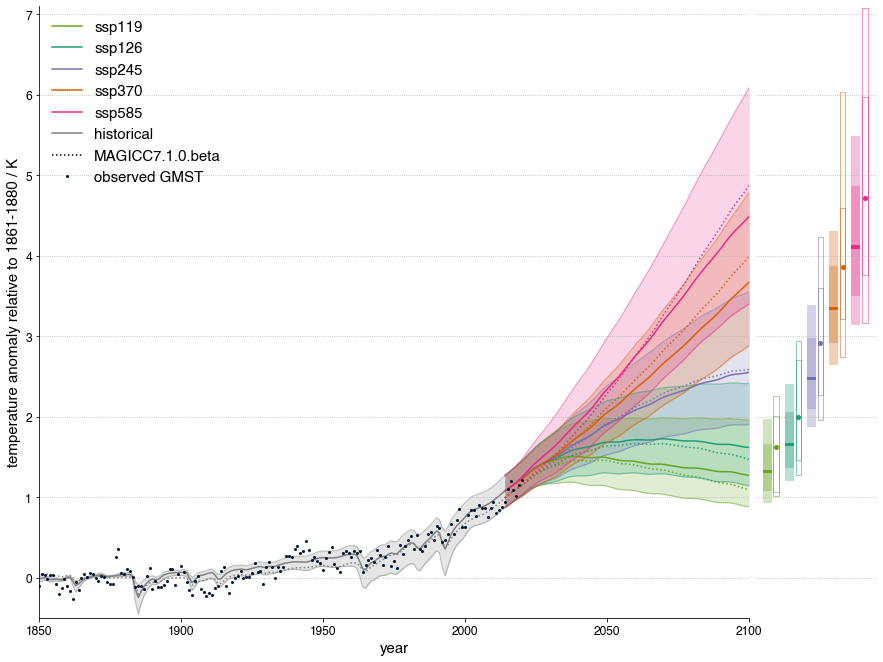

In [21]:
fig = plt.figure(figsize=(15,11.25))
gs = fig.add_gridspec(1, 20,wspace=0.2)
ax = fig.add_subplot(gs[0,:-3])

for ssp in scenarios:
    ax.plot(plot_results.loc[2014:2100,(ssp,'temp',50)],color=colors[ssp],label=ssp)
    ax.fill_between(plot_results.loc[2014:2100].index,*plot_results.loc[2014:2100,(ssp,'temp',[5,95])].values.T,color=colors[ssp],alpha=0.2,lw=0)
    ax.plot(plot_results.loc[2014:2100].index,plot_results.loc[2014:2100,(ssp,'temp',[5,95])],color=colors[ssp],lw=1.2,alpha=0.5)
    ax.plot(magicc_scm.loc['World'].xs('Surface Air Temperature Change',level=1).loc['esm-'+ssp+'-allGHG',range(2014,2101)]-magicc_scm.loc['World'].xs('Surface Air Temperature Change',level=1).loc['esm-'+ssp+'-allGHG',range(1861,1880)].mean(),color=colors[ssp],ls=':')
    
ax.plot(plot_results.loc[:2014,(ssp,'temp',50)],color=colors['history'],label='historical')
ax.fill_between(plot_results.loc[:2014].index,*plot_results.loc[:2014,(ssp,'temp',[5,95])].values.T,color=colors['history'],alpha=0.2,lw=0)
ax.plot(plot_results.loc[:2014].index,plot_results.loc[:2014,(ssp,'temp',[5,95])],color=colors['history'],lw=1.2,alpha=0.5)
ax.plot(magicc_scm.loc['World'].xs('Surface Air Temperature Change',level=1).loc['esm-'+ssp+'-allGHG',range(1850,2015)]-magicc_scm.loc['World'].xs('Surface Air Temperature Change',level=1).loc['esm-'+ssp+'-allGHG',range(1861,1880)].mean(),color=colors['history'],ls=':')
    
ax.plot([],[],'k:',label='MAGICC7.1.0.beta')
    
ax.plot(np.arange(1850,2021),(GMST_datasets.mean(axis=1) - GMST_datasets.loc['1861':'1880'].mean(axis=1).mean()).resample('y').mean().values,'.',ms=4,label='observed GMST')

ax1 = fig.add_subplot(gs[0,-3:])

for i,ssp in enumerate(scenarios):
    
    ax1.bar(i,0.04,width=0.4,bottom=plot_results.loc[2081:2100,(ssp,'temp',50)].mean()-0.02,color=colors[ssp])
    ax1.bar(i,plot_results.loc[2081:2100,(ssp,'temp',[16.6,83.3])].mean().diff(),width=0.4,bottom=plot_results.loc[2081:2100,(ssp,'temp',16.6)].mean(),color=colors[ssp],alpha=0.3)
    ax1.bar(i,plot_results.loc[2081:2100,(ssp,'temp',[5,95])].mean().diff(),width=0.4,bottom=plot_results.loc[2081:2100,(ssp,'temp',5)].mean(),color=colors[ssp],alpha=0.3)
    
    ax1.bar([i+0.4],CMIP6_ssp_statistics.loc[ssp,['min','max']].diff(),width=0.25,bottom=CMIP6_ssp_statistics.loc[ssp,'min'],color='',edgecolor=colors[ssp],lw=0.5)
    ax1.bar([i+0.4],CMIP6_ssp_statistics.loc[ssp,['16.6%','83.3%']].diff(),width=0.25,bottom=CMIP6_ssp_statistics.loc[ssp,'16.6%'],color='',edgecolor=colors[ssp],lw=0.5)
    ax1.plot([i+0.4],CMIP6_ssp_statistics.loc[ssp,'50%'],'o',ms=4,c=colors[ssp])

ax.yaxis.grid(ls=':')
ax.set_ylim(-0.5,7.1)
ax1.set_ylim(-0.5,7.1)
# ax1.axis('off')
ax1.xaxis.set_ticklabels([])
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticklabels([])
ax1.yaxis.set_ticks_position('none')
ax1.yaxis.grid(ls=':')
[ax1.spines[pos].set_visible(False) for pos in ['right','top','bottom','left']]
[ax.spines[pos].set_visible(False) for pos in ['right','top']]
ax.set_xlim(1850,2100)
ax1.set_xlim(-0.5,4.9)
ax.legend(loc='upper left',fontsize=15)
plt.tight_layout()
ax.set_ylabel('temperature anomaly relative to 1861-1880 / K',fontsize=15)
ax.set_xlabel('year',fontsize=15)
ax.tick_params(labelsize=12)
ax.ticklabel_format(style="plain")

plt.tight_layout()

# [fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/SSP_NROY_temp.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

## Default parameter historical run

In [15]:
## import concentrations:
CMIP6_conc_ftp = ftplib.FTP('data.iac.ethz.ch','anonymous')
CMIP6_conc_ftp.cwd('CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701')
CMIP6_ftp_list = [x for x in CMIP6_conc_ftp.nlst() if x[-3:]=='csv']
WMGHG_concs = pd.DataFrame(dict(zip(['_'.join(x.split('_')[3:-8]) for x in CMIP6_ftp_list],[pd.read_csv('ftp://data.iac.ethz.ch/CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701/'+x,usecols=[0,1],index_col=0).iloc[:,0] for x in CMIP6_ftp_list])))
WMGHG_concs = WMGHG_concs[[x for x in WMGHG_concs.columns if x[-2:]!='eq']] # remove "equivalent" concentrations

WMGHG_concs['halon1202'] = 0
WMGHG_concs.loc[1765:2014,'halon1202'] = pd.read_csv('http://www.pik-potsdam.de/~mmalte/rcps/data/RCP45_MIDYEAR_CONCENTRATIONS.DAT',skiprows=38,delim_whitespace=True,index_col=0)['HALON1202'].loc[1765:2014].values

NOAA_mole_fractions_2020 = pd.read_csv('https://www.esrl.noaa.gov/gmd/aggi/NOAA_MoleFractions_2020.csv',skiprows=2,index_col=0,skipfooter=5).iloc[1:].replace('nd',np.nan).apply(pd.to_numeric)

scale_factor = (WMGHG_concs.loc[2014,'carbon_dioxide'] / NOAA_mole_fractions_2020.loc[2014:2015,'CO2']).values

CO2_concs = pd.Series(np.append(WMGHG_concs.loc[1750:,'carbon_dioxide'].values.flatten(),NOAA_mole_fractions_2020.loc[2015:,'CO2']*scale_factor),index=np.arange(1750,2020),name='CO2')

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [16]:
ssp_emms = pd.concat([RCMIP_to_GIR_input_emms(x) for x in scenarios],keys=scenarios,axis=1).interpolate()
ssp_emms = ssp_emms.loc[1750:2300] - ssp_emms.loc[1750]
ssp_forc = pd.concat([get_RCMIP_forc(x) for x in scenarios],keys=scenarios,axis=1).interpolate().loc[1750:2300]

for ssp in ssp_emms.columns.levels[0]:
    sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,(ssp,'carbon_dioxide')]
    ssp_emms.loc[:2014,(ssp,'carbon_dioxide')] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
    ssp_emms.loc[2015:2025,(ssp,'carbon_dioxide')] *= np.linspace(sf,1,11)

In [17]:
default_gas_params = pd.read_csv("../Parameter_Sets/Complete_gas_cycle_params.csv",header=[0,1],index_col=0)

In [18]:
default_ssp_run = run_GIR(emissions_in=ssp_emms,forcing_in=ssp_forc,gas_parameters=default_gas_params)

Integrating 5 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'methyl_chloride|strat_o3', 'nf3', 

100%|██████████| 550/550 [00:00<00:00, 2952.79 timestep/s]


In [19]:
map_conc_names = dict(zip(WMGHG_concs.columns,['C$_2$F$_6$','C$_3$F$_8$','C$_4$F$_{10}$','C$_5$F$_{12}$','C$_6$F$_{14}$','C$_7$F$_{16}$','C$_8$F$_{18}$','cC$_4$F$_{8}$','CO$_2$','CCl$_4$','CF$_4$','CFC113','CFC114','CFC115','CFC11','CFC12','CH$_2$Cl$_2$','CH$_3$CCl$_3$','CHCl$_3$','Halon1211','Halon1301','Halon2402','HCFC141b', 'HCFC142b', 'HCFC22', 'HFC125','HFC134a', 'HFC143a', 'HFC152a', 'HFC227ea', 'HFC236fa', 'HFC23','HFC245fa', 'HFC32', 'HFC365mfc', 'HFC4310mee','CH$_4$','CH$_3$Br','CH$_3$Cl','NF$_3$','N$_2$O','SF$_6$','SO$_2$F$_2$','Halon1202']))

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


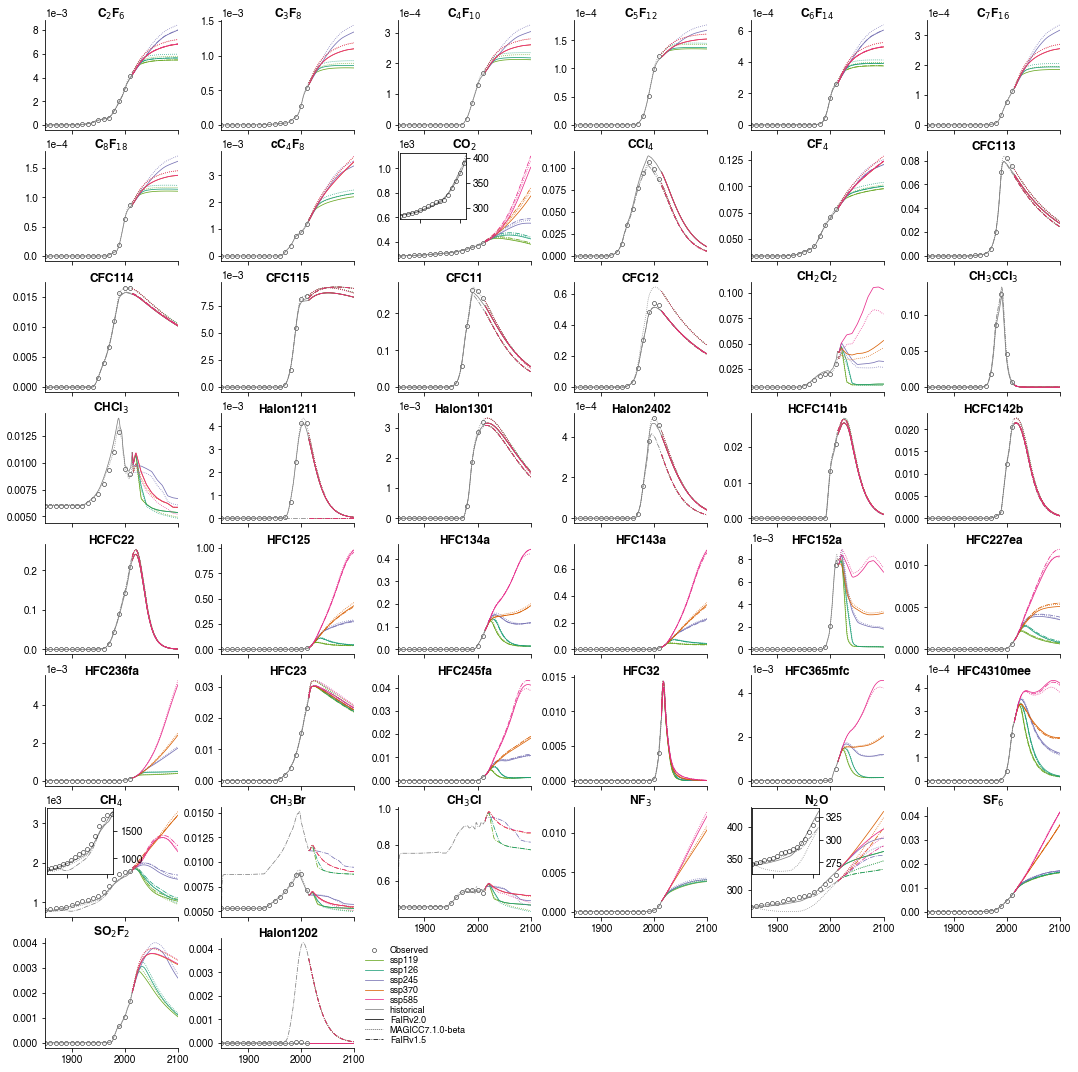

In [20]:
fig,ax = plt.subplots(8,6,figsize=(15,15))

with plt.rc_context({"lines.linewidth": 0.75,"lines.markersize":4,"lines.markerfacecolor":'none',"lines.markeredgewidth":0.5}):

    for i,gas in enumerate(WMGHG_concs.columns):

    #     ax1 = inset_axes(ax.flatten()[i],width="40%",height="40%",loc=2)
    #     ax1.patch.set_alpha(0)
    #     [ax1.spines[pos].set_visible(False) for pos in ['right','top']]

        if gas in ['nitrous_oxide','carbon_dioxide','methane']:
            ax.flatten()[i].plot(WMGHG_concs.loc[1850:,gas].iloc[::10],'o',color='k')
    #         ax1.plot(WMGHG_concs.loc[1850:,gas],'.',ms=4,)
        else:
            ax.flatten()[i].plot(WMGHG_concs.loc[1850:,gas].iloc[::10]/1000,'o',color='k',label='Observed')
    #         ax1.plot(WMGHG_concs.loc[1850:,gas]/1000,'.',ms=4,)

        for ssp in scenarios:
            ax.flatten()[i].plot(default_ssp_run['C'].loc[2014:2100,(ssp,'default',gas)],color=colors[ssp],label=ssp)

            ax.flatten()[i].plot(magicc_scm.loc[('World','esm-'+ssp+'-allGHG',GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_key']),range(2014,2101)]*GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_scaling'],color=colors[ssp],ls=':')

            try:
                ax.flatten()[i].plot(fair_scm.loc[('World','esm-'+ssp+'-allGHG',GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_key']),range(2014,2101)]*GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_scaling'],color=colors[ssp],ls='-.')
            except:
                pass

        ax.flatten()[i].plot(default_ssp_run['C'].loc[1850:2014,('ssp245','default',gas)],color=colors['history'],label='historical')
        ax.flatten()[i].plot(magicc_scm.loc[('World','esm-'+ssp+'-allGHG',GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_key']),range(1850,2015)]*GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_scaling'],color=colors['history'],ls=':')

        try:
            ax.flatten()[i].plot(fair_scm.loc[('World','esm-'+ssp+'-allGHG',GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_key']),range(1850,2014)]*GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_scaling'],color=colors['history'],ls='-.')
        except:
            pass
    #     ax1.plot(default_ssp_run['C'].loc[1850:2014,('ssp245','default',gas)],color=colors['history'])
    #     ax1.plot(magicc_scm.loc[('World','esm-'+ssp+'-allGHG',GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_key']),range(1850,2015)]*GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_scaling'],color=colors['history'],ls=':')
        ax.flatten()[i].text(0.5,0.98,map_conc_names[gas],transform=ax.flatten()[i].transAxes,va='bottom',ha='center',fontsize=12,fontweight='bold')
    #     ax1.set_xlim(1850,2014)
    #     ax1.set_xticklabels([])
    
        if gas in ['carbon_dioxide','methane','nitrous_oxide']:
            ax1 = inset_axes(ax.flatten()[i],width="100%",height="100%",bbox_to_anchor=(0.05,0.43,0.5,0.6),bbox_transform=ax.flatten()[i].transAxes)
            ax1.plot(default_ssp_run['C'].loc[1850:2014,('ssp245','default',gas)],color=colors['history'])
            ax1.plot(magicc_scm.loc[('World','esm-'+ssp+'-allGHG',GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_key']),range(1850,2015)]*GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_scaling'],color=colors['history'],ls=':')
            ax1.plot(fair_scm.loc[('World','esm-'+ssp+'-allGHG',GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_key']),range(1850,2014)]*GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_scaling'],color=colors['history'],ls='-.')
            ax1.plot(WMGHG_concs.loc[1850:,gas].iloc[::10],'o',color='k')
            ax1.set_xticklabels([])
            ax1.tick_params(left=False,labelleft=False,right=True,labelright=True)
            ax1.ticklabel_format(axis='y',style="plain")
            ax1.set_xlim(1850,2014)

    [a.tick_params(labelbottom=False) for a in ax.flatten()]
    [a.tick_params(labelbottom=True) for a in ax.flatten()[-10:]]
    [a.ticklabel_format(style="plain") for a in ax.flatten()[-10:]]
#     [a.set_xlabel("year") for a in ax.flatten()[-10:]]
    [a.set_xlim(1850,2100) for a in ax.flatten()]
    [a.spines[pos].set_visible(False) for pos in ['right','top'] for a in ax.flatten()]
    
    ax.flatten()[-5].plot([],[],'k',label='FaIRv2.0')
    ax.flatten()[-5].plot([],[],'k:',label='MAGICC7.1.0-beta')
    ax.flatten()[-5].plot([],[],'k-.',label='FaIRv1.5')

#     fig.subplots_adjust(hspace=0.1)
    
    plt.tight_layout(h_pad=0,w_pad=0)
    
    ax.flatten()[-5].legend(loc=(1.05,0),labelspacing=0.1,prop={'size':9})

    [a.set_visible(False) for a in ax.flatten()[-4:]]

    [fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/SSP_concs.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

## Default parameter RCP run:_

In [32]:
## RCMIP SSP emissions:
scenarios = ['rcp'+x for x in ['26','45','60','85']]#['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
rcp_emms = pd.concat([RCMIP_to_GIR_input_emms(x).dropna(axis=1,how='all').dropna() for x in scenarios],keys=scenarios,axis=1).interpolate()
rcp_emms = rcp_emms.loc[1750:2150] - rcp_emms.loc[1765]
rcp_forc = pd.concat([get_RCMIP_forc(x,drivers=['Radiative Forcing|Natural','Radiative Forcing|Anthropogenic|Albedo Change']) for x in scenarios],keys=scenarios,axis=1).interpolate().loc[1765:2150]

# ## switch in GCP co2 emissions up to start of SSPs
# GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# # set 1750 value to 0
# GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# # linearly interpolate between 0 and first land-use-change datapoint
# GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

# for ssp in ssp_emms.columns.levels[0]:
#     sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,(ssp,'carbon_dioxide')]
#     ssp_emms.loc[:2014,(ssp,'carbon_dioxide')] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
#     ssp_emms.loc[2015:2025,(ssp,'carbon_dioxide')] *= np.linspace(sf,1,11)

In [33]:
rcp_run1 = run_GIR(emissions_in=rcp_emms,forcing_in=rcp_forc,gas_parameters=pd.concat([default_params.reindex([x for x in default_params.columns if x.split('|')[0] in rcp_emms.columns.levels[-1]],axis=1)],axis=1,keys=['default']))

Integrating 4 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c6f14', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch3ccl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc227ea', 'hfc23', 'hfc245fa', 'hfc32', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nitrous_oxide', 'sf6', 'halon1202', 'so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon2402|strat_o3', 'hcfc141b|strat_o3', 'hcfc142b|strat_o3', 'hcfc22|strat_o3', 'methyl_bromide|strat_o3', 'methyl_chloride|strat_o3', 'halon1202|strat_o3'] for

100%|██████████| 385/385 [00:00<00:00, 2993.75 timestep/s]


In [43]:
(rcp_run1['alpha'].xs('methane',axis=1,level=-1)*8.8).loc[2100]

Scenario  Gas cycle set
rcp26     default           8.746771
rcp45     default           8.837552
rcp60     default           8.683740
rcp85     default          10.308045
Name: 2100, dtype: float64

# Appendix: CMIP6-like ensemble
This essentially generates the FULL parameter ensemble as in "NROY_generation", but without mapping the aerosol parameters to match the process-based assessment (ie. the aerosol parameter distributions are inferred directly from CMIP6 samples.

Need to think about correlations between prior distributions more carefully...

In [6]:
## create parameter ensemble

### do we go for sampling gaussian forcings / non-gaussian forcings / carbon-cycle parameters / response parameters independently
### and assuming all uncertainties within these categories are correlated?

def get_forcing_param_ensemble(N,mem_names = False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    category_distributions = pd.Series(index = param_categories.keys(),dtype=object)

    category_distributions.loc['carbon_dioxide'] = sp.stats.norm(1,0.20/1.645)
    category_distributions.loc['methane'] = sp.stats.norm(1,0.28/1.645)
    category_distributions.loc['nitrous_oxide'] = sp.stats.norm(1,0.2/1.645)
    category_distributions.loc['other_wmghgs'] = sp.stats.norm(1,0.20/1.645)
    category_distributions.loc['trop_o3'] = sp.stats.norm(1,0.5/1.645)
    category_distributions.loc['strat_o3'] = sp.stats.norm(1,2/1.645)
    category_distributions.loc['strat_h2o'] = sp.stats.norm(1,0.72/1.645)
    pct_5 = 0.04 / 0.08 # need to scale by the mean to turn into a "scaling factor"
    pct_95=0.18 / 0.08
    sigma = (np.log(pct_95) - np.log(pct_5)) / (sp.stats.norm().ppf(0.95)-sp.stats.norm().ppf(0.05))
    mu = np.log(pct_5) - sigma * sp.stats.norm().ppf(0.05)
    category_distributions.loc['bc_on_snow'] = sp.stats.lognorm(s=sigma,scale=np.exp(mu))
    category_distributions.loc['contrails'] = sp.stats.norm(1,0.75/1.645)

    f_parameter_ensemble_draw = np.zeros((3,len(forcing_namelist),N))
    default_f_params = default_params.loc['f1':'f3'].values

    for key in category_distributions.index:
        if not type(category_distributions.loc[key]) == sp.stats._distn_infrastructure.rv_frozen:
            continue
        cat_map = [x in param_categories[key] for x in forcing_namelist]
        f_parameter_ensemble_draw[:,cat_map,:] = default_f_params[:,cat_map,None] * category_distributions.loc[key].rvs(N)[None,None]
        
    ## draw aerosol parameters based on inferred CMIP6 ranges (see CMIP6_parameter_ranges notebook), then rescaled to match the Bellouin process based assessment

    ## compute parameters, then scale by the Bellouin / 1850-(2005:2015)
    
    ERFari_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFari.csv',index_col=0)
    
    ERFari_mean = ERFari_params.mean().values
    ERFari_cov = ERFari_params.cov().values

    ERFari_param_draw = sp.stats.multivariate_normal(ERFari_mean,ERFari_cov).rvs(N)
    
    ERFaci_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFaci.csv',index_col=0)
    
    ERFaci_ln_beta_s_cov = ERFaci_params[['log_beta','log_beta_s']].cov().values
    ERFaci_ln_beta_s_mean = ERFaci_params[['log_beta','log_beta_s']].mean().values
    ERFaci_alpha_mean = ERFaci_params['alpha'].mean()
    ERFaci_alpha_std = ERFaci_params['alpha'].std()

    ERFaci_beta_s = np.exp(sp.stats.multivariate_normal(ERFaci_ln_beta_s_mean,ERFaci_ln_beta_s_cov).rvs(N))
    ERFaci_alpha = sp.stats.norm(ERFaci_alpha_mean,ERFaci_alpha_std).rvs(N)
    ERFaci_beta = -1*ERFaci_beta_s[...,0]
    ERFaci_s = ERFaci_beta_s[...,0] / ERFaci_beta_s[...,1]
    
    for i,cat in enumerate(['bc','oc','so2']):
        cat_map = forcing_namelist.index(cat)
        f_parameter_ensemble_draw[1,cat_map,:] = ERFari_param_draw[...,i]

    so2_PI_conc_ensemble = ERFaci_s.copy()

    cat_map = forcing_namelist.index('so2|aci')
    f_parameter_ensemble_draw[0,cat_map,:] = ERFaci_beta

    cat_map = forcing_namelist.index('oc|aci')
    f_parameter_ensemble_draw[1,cat_map,:] = ERFaci_alpha
    cat_map = forcing_namelist.index('bc|aci')
    f_parameter_ensemble_draw[1,cat_map,:] = ERFaci_alpha
    
    gas_parameter_ensemble = pd.concat([default_params.copy()]*N,axis=1,keys=mem_names)

    gas_parameter_ensemble.loc['f1':'f3',:] = f_parameter_ensemble_draw.swapaxes(1,2).reshape(3,-1)[:]

    gas_parameter_ensemble.loc['PI_conc',(slice(None),'so2')] = so2_PI_conc_ensemble[:]
    
    return gas_parameter_ensemble

In [7]:
def get_response_params(N,gas_parameter_ensemble,mem_names = False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    ## require gas_params for the F_2x value

    ## draw ln d1, ln d2, q1 | ln d3 | RWF | TCR

    # covariance of ln_d1, d2, q1
    cov_mat_1 = np.array([[0.95199915, 0.47649902, 0.09359745], [0.47649902, 0.59388914, 0.09119872], [0.09359745, 0.09119872, 0.01710808]])

    mean_mat_1 = np.array([-0.20227299,  2.05243353,  0.20285564])
    
    ln_d3_mean = 5.76338587
    ln_d3_std = 0.57722689
    
    # we alter the CMIP6 assessed ranges to cover a slighly wider range
    RWF_mean = 0.55 # 0.55124171
    RWF_std = 0.3/1.645 # 0.13777385
    
    TCR_mean = 2# 2.0782074
    TCR_std = 1/1.645# 0.45012178

    F_2x = gas_parameter_ensemble.loc['f1',(slice(None),'carbon_dioxide')].values * np.log(2) + gas_parameter_ensemble.loc['f3',(slice(None),'carbon_dioxide')].values * (np.sqrt(278*2) - np.sqrt(278))

    lnd1 , lnd2 , q1 , RWF , lnd3 , TCR , d1, d2, d3 , ECS , v1 , v2 , v3 , q2 , q3 = np.empty((15,N))

    neg_idx = np.ones(N).astype(bool)
    N_neg = neg_idx.sum()

    while N_neg>0:

        lnd1[neg_idx], lnd2[neg_idx], q1[neg_idx] = sp.stats.multivariate_normal(mean_mat_1,cov_mat_1).rvs(N_neg).T
        lnd3[neg_idx] = sp.stats.norm(ln_d3_mean, ln_d3_std).rvs(N_neg)
        RWF[neg_idx] = sp.stats.truncnorm(-3,3,RWF_mean, 0.15).rvs(N_neg)
        TCR[neg_idx] = sp.stats.truncnorm(-3,3,TCR_mean, TCR_std).rvs(N_neg)
#         RWF[neg_idx] = sp.stats.uniform(0.2,0.65).rvs(N_neg)
#         TCR[neg_idx] = sp.stats.uniform(0.5,3).rvs(N_neg)
        d1[neg_idx] = np.exp(lnd1[neg_idx])
        d2[neg_idx] = np.exp(lnd2[neg_idx])
        d3[neg_idx] = np.exp(lnd3[neg_idx])
        ECS[neg_idx] = TCR[neg_idx]/RWF[neg_idx]

        v1[neg_idx] = (1-(d1/69.66) * (1-np.exp(-69.66/d1)) )[neg_idx]
        v2[neg_idx] = (1-(d2/69.66) * (1-np.exp(-69.66/d2)) )[neg_idx]
        v3[neg_idx] = (1-(d3/69.66) * (1-np.exp(-69.66/d3)) )[neg_idx]

        q3[neg_idx] = (((TCR/F_2x) - q1*(v1-v2) - (ECS/F_2x)*v2) / (v3-v2))[neg_idx]
        q2[neg_idx] = (ECS/F_2x - q1 -  q3)[neg_idx]

        neg_idx = np.any(np.array([d1,d2,d3,q1,q2,q3])<0,axis=0)
        N_neg = neg_idx.sum()

    response_par_ensemble = np.array([d1,d2,d3,q1,q2,q3]).T
    thermal_parameter_ensemble = pd.concat([get_thermal_parameter_defaults()['default'].copy()]*N,axis=1,keys=mem_names)
    thermal_parameter_ensemble.loc[:] = response_par_ensemble.reshape(N,2,3).swapaxes(0,1).reshape(2,-1)
    
    return thermal_parameter_ensemble

In [8]:
## NEED TO CHECK THIS AND ENSURE CONSISTENT RESULTS WITH full NROY

def generate_CMIP6like_params(N):
    
    mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    # forcing uncertainty
    ## anothropogenic
    gas_parameter_ensemble = get_forcing_param_ensemble(N,mem_names=mem_names)
    
    LUC_forc_sfs = sp.stats.norm(1,0.75/1.645).rvs(N)
    
    volc_forc_sfs = sp.stats.norm(1,0.5/1.645).rvs(N)
    
    sol_forc_sfs = sp.stats.norm(1,1/1.645).rvs(N)
    
    # carbon cycle uncertainty
#     cc_uncertainty = 0.13 / 1.645 * (4.165 / 3.587)
#     cc_param_draw = sp.stats.norm(1,cc_uncertainty).rvs(N).reshape(1,-1)
#     gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')] = gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')].values * cc_param_draw
    cc_params = pd.read_csv('../Parameter_Sets/CMIP6_1pctCO2_cc_200820_byOLSE.csv',index_col=0).astype(float)
    r0_draw = sp.stats.norm(1,cc_params.r0.std()/cc_params.r0.mean()).rvs(N)
    rC_draw = np.exp(sp.stats.norm(np.log(1),abs(np.log(cc_params.rC).std()/np.log(cc_params.rC).mean())).rvs(N))
    rT_draw = sp.stats.norm(1,cc_params.rT.std()/cc_params.rT.mean()).rvs(N)
    gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')] = gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')].values * np.array([r0_draw,rC_draw,rT_draw])
    
    # response uncertainty
    thermal_parameter_ensemble = get_response_params(N,gas_parameter_ensemble,mem_names)
    
    return gas_parameter_ensemble,thermal_parameter_ensemble,LUC_forc_sfs,volc_forc_sfs,sol_forc_sfs

def run_CMIP6like_ssp(ssp,gas_parameter_ensemble,thermal_parameter_ensemble,LUC_forc_sfs,volc_forc_sfs,sol_forc_sfs):

    ssp_emms = RCMIP_to_GIR_input_emms(ssp).interpolate().reindex(np.arange(1750,2151))
    ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values
    sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,'carbon_dioxide']
    ssp_emms.loc[:2014,'carbon_dioxide'] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
    ssp_emms.loc[2015:2025,'carbon_dioxide'] *= np.linspace(sf,1,11)
    
    mem_names = gas_parameter_ensemble.columns.levels[0]
    N = gas_parameter_ensemble.columns.levels[0].size
    
    erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float)
    ## LUC
    LUC_forc = erf_ar6[['land_use']].reindex(np.arange(1750,2151)).values
    LUC_forc_ensemble = LUC_forc_sfs[None] * LUC_forc
    
    ## Natural
    volc_forc = erf_ar6[['volcanic']].reindex(np.arange(1750,2151)).values
    volc_forc_ensemble = volc_forc_sfs[None] * volc_forc
    sol_forc = erf_ar6[['solar']].reindex(np.arange(1750,2151)).values
    sol_forc_ensemble = sol_forc_sfs[None] * sol_forc
    
    ext_forc_sfs = pd.DataFrame([LUC_forc_sfs,volc_forc_sfs,sol_forc_sfs],index=['LUC','volc','sol'],columns = mem_names)
    
    ssp_forc = pd.DataFrame(LUC_forc_ensemble+sol_forc_ensemble+volc_forc_ensemble,index=np.arange(1750,2151),columns=pd.MultiIndex.from_product([mem_names,['forcing']]) )

    ssp_emms_run = pd.concat([ssp_emms]*N,axis=1,keys=gas_parameter_ensemble.columns.levels[0])

    results = run_GIR(emissions_in=ssp_emms_run,forcing_in=ssp_forc,gas_parameters=gas_parameter_ensemble,thermal_parameters=thermal_parameter_ensemble)

    return results['RF'],results['T'],LUC_forc_ensemble

In [9]:
scenarios = ['ssp'+x for x in ['119','126','245','370','585']]

plot_results = pd.DataFrame(index = np.arange(1750,2151),columns=pd.MultiIndex.from_product([scenarios,list(param_categories.keys()) + ['anthro','temp'],[5,17,50,83,95]]))

generate_params = generate_CMIP6like_params(5000)

for ssp in scenarios:
    
    results_rf,results_T,LUC_forc = run_CMIP6like_ssp(ssp,*generate_params)
    
    for forc_cat in param_categories.keys():
        for quantile in [5,16.6,50,83.3,95]:
            plot_results.loc[:,(ssp,forc_cat,quantile)] = results_rf.loc[:,(slice(None),param_categories[forc_cat])].groupby(level=0,axis=1).sum().quantile(quantile/100,axis=1)
            
    for quantile in [5,16.6,50,83.3,95]:
        plot_results.loc[:,(ssp,'anthro',quantile)] = (results_rf.xs('Total',axis=1,level=1) - results_rf.xs('External',axis=1,level=1) + LUC_forc).quantile(quantile/100,axis=1)
        plot_results.loc[:,(ssp,'temp',quantile)] = (results_T - results_T.loc[1861:1880].mean()).quantile(quantile/100,axis=1)

Integrating 5000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'ha

100%|██████████| 400/400 [00:16<00:00, 24.01 timestep/s]


Integrating 5000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'ha

100%|██████████| 400/400 [00:16<00:00, 24.25 timestep/s]


Integrating 5000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'ha

100%|██████████| 400/400 [00:15<00:00, 25.56 timestep/s]


Integrating 5000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'ha

100%|██████████| 400/400 [00:16<00:00, 24.46 timestep/s]


Integrating 5000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'ha

100%|██████████| 400/400 [00:15<00:00, 25.11 timestep/s]


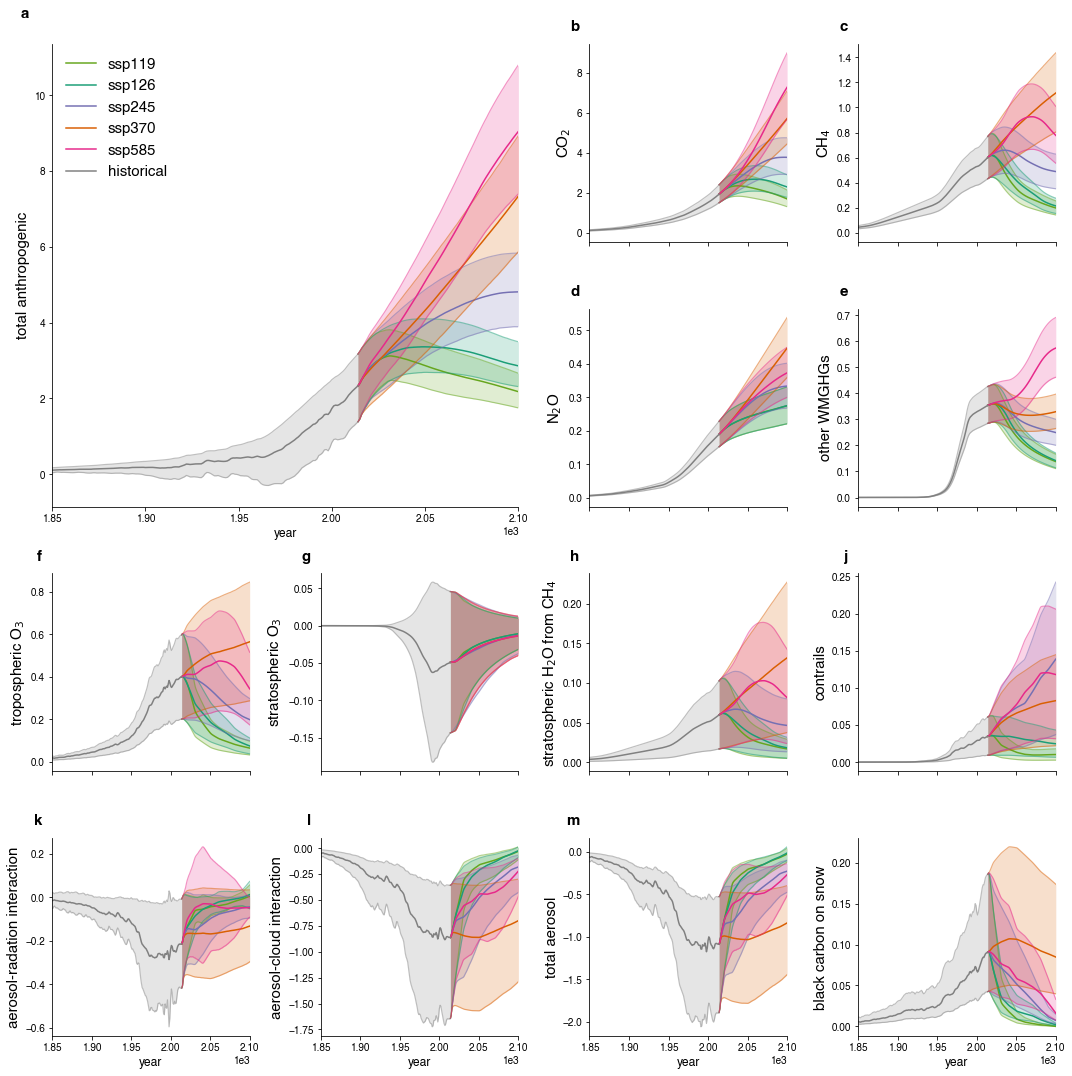

In [10]:
fig=plt.figure(figsize=(15,15))

map_forc_cat = dict(zip(param_categories.keys(),['other WMGHGs','CO$_2$','CH$_4$','N$_2$O','tropospheric O$_3$','stratospheric O$_3$','stratospheric H$_2$O from CH$_4$','aerosol-radation interaction','aerosol-cloud interaction','total aerosol','black carbon on snow','contrails']))
forc_cat_order = ['carbon_dioxide', 'methane', 'nitrous_oxide','other_wmghgs','trop_o3', 'strat_o3', 'strat_h2o','contrails','ari', 'aci', 'aer','bc_on_snow']

gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[:2,:2])
ax2 = [fig.add_subplot(gs[i,j]) for i in np.arange(4) for j in np.arange(4) if (i>=2) or (j>=2)]
colors= {'ssp245':'#7570b3','ssp370':'#d95f02','ssp585':'#e7298a','ssp119':'#66a61e','ssp126':'#1b9e77','history':'grey'}
for ssp in scenarios:
    ax1.plot(plot_results.loc[2014:2100,(ssp,'anthro',50)],color=colors[ssp],label=ssp)
    ax1.fill_between(plot_results.loc[2014:2100].index,*plot_results.loc[2014:2100,(ssp,'anthro',[5,95])].values.T,color=colors[ssp],lw=0,alpha=0.2)
    ax1.plot(plot_results.loc[2014:2100].index,plot_results.loc[2014:2100,(ssp,'anthro',[5,95])],color=colors[ssp],lw=1.2,alpha=0.5)
    
#     ax1.plot(magicc_data.loc[2014:2100].index,magicc_data.loc[2014:2100,(ssp,'anthro')],color=colors[ssp],ls=':',lw=1.2,alpha=0.5)
    
    for i,forc_cat in enumerate(forc_cat_order):
        ax2[i].plot(plot_results.loc[2014:2100,(ssp,forc_cat,50)],color=colors[ssp])
        ax2[i].fill_between(plot_results.loc[2014:2100].index,*plot_results.loc[2014:2100,(ssp,forc_cat,[5,95])].values.T,color=colors[ssp],lw=0,alpha=0.2)
        ax2[i].plot(plot_results.loc[2014:2100].index,plot_results.loc[2014:2100,(ssp,forc_cat,[5,95])],color=colors[ssp],lw=1.2,alpha=0.5)
        
#         ax2[i].plot(magicc_data.loc[2014:2100].index,magicc_data.loc[2014:2100,(ssp,forc_cat)],color=colors[ssp],ls=':',lw=1.2,alpha=0.5)
        
ax1.plot(plot_results.loc[:2014,(ssp,'anthro',50)],color=colors['history'],label='historical')
ax1.fill_between(plot_results.loc[:2014].index,*plot_results.loc[:2014,(ssp,'anthro',[5,95])].values.T,color=colors['history'],lw=0,alpha=0.2)
ax1.plot(plot_results.loc[:2014].index,plot_results.loc[:2014,(ssp,'anthro',[5,95])],color=colors['history'],lw=1.2,alpha=0.5)

# ax1.plot(magicc_data.loc[:2014].index,magicc_data.loc[:2014,(ssp,'anthro')],color=colors['history'],ls=':',lw=1.2,alpha=0.5)

for i,forc_cat in enumerate(forc_cat_order):
        ax2[i].plot(plot_results.loc[:2014,(ssp,forc_cat,50)],color=colors['history'])
        ax2[i].fill_between(plot_results.loc[:2014].index,*plot_results.loc[:2014,(ssp,forc_cat,[5,95])].values.T,color=colors['history'],lw=0,alpha=0.2)
        ax2[i].plot(plot_results.loc[:2014].index,plot_results.loc[:2014,(ssp,forc_cat,[5,95])],color=colors['history'],lw=1.2,alpha=0.5)
        
#         ax2[i].plot(magicc_data.loc[:2014].index,magicc_data.loc[:2014,(ssp,forc_cat)],color=colors['history'],ls=':',lw=1.2,alpha=0.5)
        
        ax2[i].set_ylabel(map_forc_cat[forc_cat],fontsize=15)

        
ax1.set_ylabel('total anthropogenic',fontsize=15)
[a.tick_params(labelbottom=False) for a in ax2[:-4]]
[a.set_xlabel('year',fontsize=12) for a in ax2[-4:]+[ax1]]
[a.spines[pos].set_visible(False) for a in ax2+[ax1] for pos in ['right','top']]
[a.set_xlim(1850,2100) for a in ax2+[ax1]]
[ax2[i].text(-0.05,1.05,x,va='bottom',ha='right',transform=ax2[i].transAxes,fontweight='bold',fontsize=15) for i,x in enumerate(['b','c','d','e','f','g','h','j','k','l','m'])]
ax1.text(-0.05,1.05,'a',va='bottom',ha='right',transform=ax1.transAxes,fontweight='bold',fontsize=15)
# ax1.plot([],[],'k:',label='MAGICC7.1.0.beta')
ax1.legend(loc='upper left',fontsize=15)
plt.tight_layout()

# [fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/SSP_NROY_ERF_grid.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

In [11]:
## Import some temperature data
baseline = ['1850','1900']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [12]:
## get some CMIP6 model data

## get the actual historical / ssp data:
ssp_tas = pd.read_csv('../tools/cmip6_data/ssp_tas.csv',index_col=0)
hist_tas = pd.read_csv('../tools/cmip6_data/hist_tas.csv',index_col=0).iloc[1:]

for i,x in enumerate(['source','member','variable','experiment']):
    ssp_tas.loc[x] = [x.split('_')[i+1] for x in ssp_tas.columns]
for i,x in enumerate(['source','member']):    
    hist_tas.loc[x] = [x.split('_')[i+1] for x in hist_tas.columns]
    

ssp_tas=ssp_tas.T.set_index(['source','member','experiment']).T.drop('variable').apply(pd.to_numeric)
hist_tas=hist_tas.T.set_index(['source','member']).T.apply(pd.to_numeric)
ssp_tas['year']=[int(x) for x in ssp_tas.index]
ssp_tas = ssp_tas.set_index('year')
ssp_tas = ssp_tas.reindex(np.arange(1850,2301))

hist_tas['year']=[int(x) for x in hist_tas.index]
hist_tas = hist_tas.set_index('year')

for modmem in hist_tas.columns:
    if modmem in ssp_tas.columns.droplevel(-1):
        for exp in ssp_tas.loc[1850:2014,modmem].columns:
            ssp_tas.loc[1850:2014,(*modmem,exp)] = hist_tas.loc[1850:2014,modmem]
            
baseline = [1861,1880]

plot_cmip6_tas2100 = ssp_tas.drop(('KACE-1-0-G','r3i1p1f1'),axis=1).groupby(level=(0,2),axis=1).mean()
plot_cmip6_tas2100 = plot_cmip6_tas2100 - plot_cmip6_tas2100.loc[baseline[0]:baseline[1]].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/leachl/miniconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [13]:
CMIP6_ssp_statistics = plot_cmip6_tas2100.loc[2081:2100].T.drop_duplicates().T.mean().groupby(level=1).describe(percentiles=[0.166,0.5,0.833])

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[None, None, None]

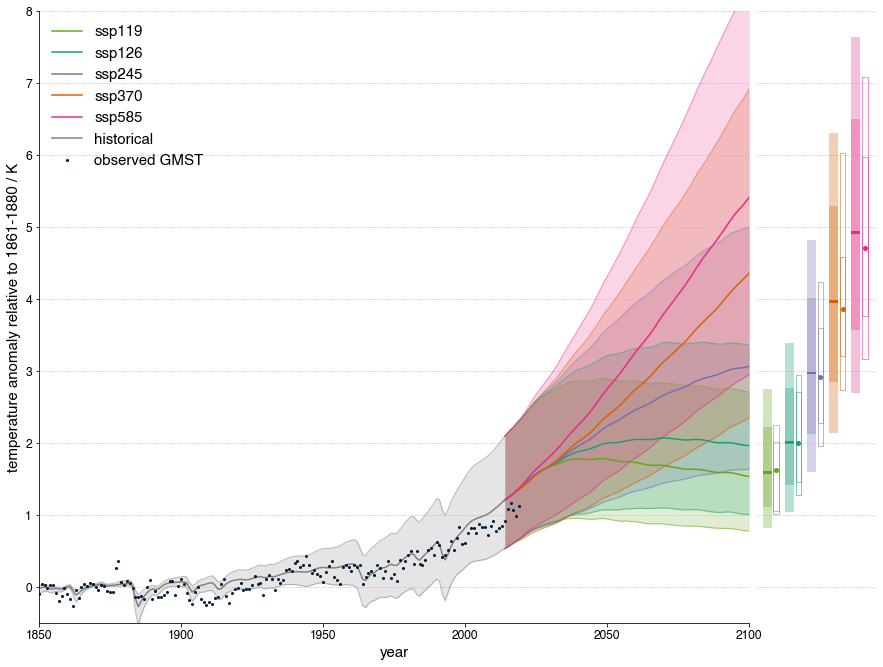

In [15]:
fig = plt.figure(figsize=(15,11.25))
gs = fig.add_gridspec(1, 20,wspace=0.2)
ax = fig.add_subplot(gs[0,:-3])

for ssp in scenarios:
    ax.plot(plot_results.loc[2014:2100,(ssp,'temp',50)],color=colors[ssp],label=ssp)
    ax.fill_between(plot_results.loc[2014:2100].index,*plot_results.loc[2014:2100,(ssp,'temp',[5,95])].values.T,color=colors[ssp],alpha=0.2,lw=0)
    ax.plot(plot_results.loc[2014:2100].index,plot_results.loc[2014:2100,(ssp,'temp',[5,95])],color=colors[ssp],lw=1.2,alpha=0.5)
#     ax.plot(magicc_scm.loc['World'].xs('Surface Air Temperature Change',level=1).loc['esm-'+ssp+'-allGHG',range(2014,2101)]-magicc_scm.loc['World'].xs('Surface Air Temperature Change',level=1).loc['esm-'+ssp+'-allGHG',range(1861,1880)].mean(),color=colors[ssp],ls=':')
    
ax.plot(plot_results.loc[:2014,(ssp,'temp',50)],color=colors['history'],label='historical')
ax.fill_between(plot_results.loc[:2014].index,*plot_results.loc[:2014,(ssp,'temp',[5,95])].values.T,color=colors['history'],alpha=0.2,lw=0)
ax.plot(plot_results.loc[:2014].index,plot_results.loc[:2014,(ssp,'temp',[5,95])],color=colors['history'],lw=1.2,alpha=0.5)
# ax.plot(magicc_scm.loc['World'].xs('Surface Air Temperature Change',level=1).loc['esm-'+ssp+'-allGHG',range(1850,2015)]-magicc_scm.loc['World'].xs('Surface Air Temperature Change',level=1).loc['esm-'+ssp+'-allGHG',range(1861,1880)].mean(),color=colors['history'],ls=':')
    
# ax.plot([],[],'k:',label='MAGICC7.1.0.beta')
    
ax.plot(np.arange(1850,2020),(GMST_datasets - GMST_datasets.loc['1861':'1880'].mean()).loc[:'2019'].mean(axis=1).resample('y').mean().values,'.',ms=4,label='observed GMST')

ax1 = fig.add_subplot(gs[0,-3:])

for i,ssp in enumerate(scenarios):
    
    ax1.bar(i,0.04,width=0.4,bottom=plot_results.loc[2081:2100,(ssp,'temp',50)].mean()-0.02,color=colors[ssp])
    ax1.bar(i,plot_results.loc[2081:2100,(ssp,'temp',[16.6,83.3])].mean().diff(),width=0.4,bottom=plot_results.loc[2081:2100,(ssp,'temp',16.6)].mean(),color=colors[ssp],alpha=0.3)
    ax1.bar(i,plot_results.loc[2081:2100,(ssp,'temp',[5,95])].mean().diff(),width=0.4,bottom=plot_results.loc[2081:2100,(ssp,'temp',5)].mean(),color=colors[ssp],alpha=0.3)
    
    ax1.bar([i+0.4],CMIP6_ssp_statistics.loc[ssp,['min','max']].diff(),width=0.25,bottom=CMIP6_ssp_statistics.loc[ssp,'min'],color='',edgecolor=colors[ssp],lw=0.5)
    ax1.bar([i+0.4],CMIP6_ssp_statistics.loc[ssp,['16.6%','83.3%']].diff(),width=0.25,bottom=CMIP6_ssp_statistics.loc[ssp,'16.6%'],color='',edgecolor=colors[ssp],lw=0.5)
    ax1.plot([i+0.4],CMIP6_ssp_statistics.loc[ssp,'50%'],'o',ms=4,c=colors[ssp])

ax.yaxis.grid(ls=':')
ax.set_ylim(-0.5,8)
ax1.set_ylim(-0.5,8)
# ax1.axis('off')
ax1.xaxis.set_ticklabels([])
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticklabels([])
ax1.yaxis.set_ticks_position('none')
ax1.yaxis.grid(ls=':')
[ax1.spines[pos].set_visible(False) for pos in ['right','top','bottom','left']]
[ax.spines[pos].set_visible(False) for pos in ['right','top']]
ax.set_xlim(1850,2100)
ax1.set_xlim(-0.5,4.9)
ax.legend(loc='upper left',fontsize=15)
plt.tight_layout()
ax.set_ylabel('temperature anomaly relative to 1861-1880 / K',fontsize=15)
ax.set_xlabel('year',fontsize=15)
ax.tick_params(labelsize=12)
ax.ticklabel_format(style="plain")

plt.tight_layout()

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/SSP_NROY_temp_CMIP6like.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

## Appendix: Interactive Plotly figure: export data
Needs the NROY ensemble to have been run.

In [21]:
plot_cmip6_tas2100.to_csv('../../../FaIR_projection_interactive/CMIP6_models.csv')

In [11]:
plot_results.xs('temp',level=1,axis=1).dropna(axis=1).sort_index(axis=1).to_csv('../../../FaIR_projection_interactive/CONSTRAINED_temp_percentiles.csv')

In [23]:
GMST_datasets.to_csv('../../../FaIR_projection_interactive/observed_GMST_rel_to_1850_1900.csv')

# Appendix : time to 1.5 / 2 C?

In [10]:
scenarios = ['ssp'+x for x in ['119','126','245','370','585']]
param_sets = get_GWI_ensemble_parameters(ensemble_size=15000)

temp_results = []

for ssp in scenarios:
    
    temp_results += [run_GWI_NROY_ssp(ssp,*param_sets)[1]]

Integrating 15193 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'methyl_chloride|strat_o3', 'nf

100%|██████████| 400/400 [00:45<00:00,  8.80 timestep/s]


Integrating 15193 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'methyl_chloride|strat_o3', 'nf

100%|██████████| 400/400 [00:42<00:00,  9.42 timestep/s]


Integrating 15193 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'methyl_chloride|strat_o3', 'nf

100%|██████████| 400/400 [00:42<00:00,  9.33 timestep/s]


Integrating 15193 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'methyl_chloride|strat_o3', 'nf

100%|██████████| 400/400 [00:41<00:00,  9.61 timestep/s]


Integrating 15193 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'methyl_chloride|strat_o3', 'nf

100%|██████████| 400/400 [00:41<00:00,  9.61 timestep/s]


In [11]:
temp_results_SSPs = pd.concat(temp_results,axis=1,keys=scenarios)

### Threshold crossing

In [12]:
## Import some temperature data
baseline = ['1850','1900']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [5]:
## check HadCRUT5 temperature
HadCRUT5_analysis = pd.read_csv("https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT5.0Analysis_gl.txt",delim_whitespace=True,index_col=0,header=None).iloc[::2,-1].rename('HadCRUT5_annual')

In [14]:
(HadCRUT5_analysis-HadCRUT5_analysis.loc[1861:1880].mean()).loc[2010:2018].mean()

1.0549166666666667

In [15]:
## two baseline options
# baseline = HadCRUT5_analysis.loc[2010:2019].mean()-HadCRUT5_analysis.loc[1861:1880].mean()
baseline = GMST_datasets.loc['2010':'2019'].mean(axis=1).mean() - GMST_datasets.loc['1861':'1880'].mean(axis=1).mean()

In [16]:
year_15_cross = ((temp_results_SSPs - temp_results_SSPs.loc[2010:2019].mean() + baseline).rolling(11,center=True).mean()>1.5).idxmax().replace(1755,np.nan).replace(1750,np.nan)
year_2_cross = ((temp_results_SSPs - temp_results_SSPs.loc[2010:2019].mean() + baseline).rolling(11,center=True).mean()>2).idxmax().replace(1755,np.nan).replace(1750,np.nan)

In [17]:
year_2_cross.to_csv('../../../FaIR_projection_interactive/NROY_time_to_20.csv')
year_15_cross.to_csv('../../../FaIR_projection_interactive/NROY_time_to_15.csv')

In [18]:
temp_results_ssps_percentiles = (temp_results_SSPs - temp_results_SSPs.loc[2010:2019].mean() + baseline)#.rolling(11,center=True).mean()
temp_results_ssps_percentiles = pd.concat([temp_results_ssps_percentiles[x].quantile([0.05,0.17,0.333,0.5,0.666,0.83,0.95],axis=1).T for x in scenarios],axis=1,keys=scenarios)
temp_results_ssps_percentiles.to_csv('../../../FaIR_projection_interactive/temp_results_2010_19_baseline.csv')

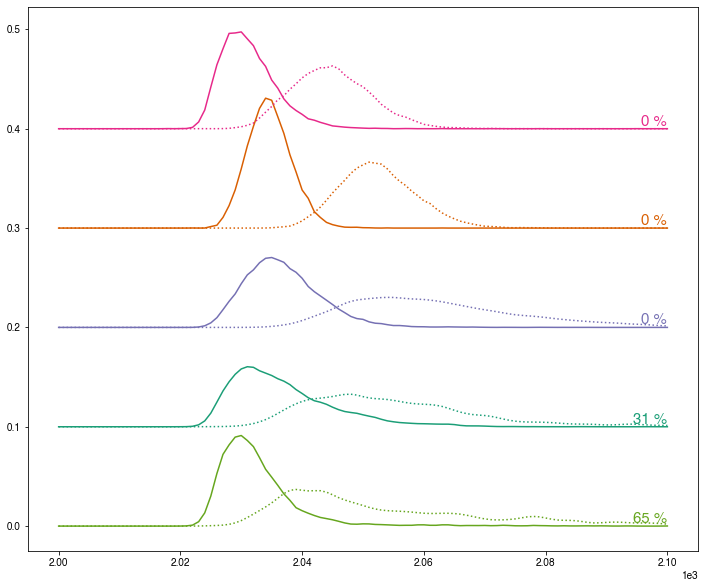

In [19]:
fig,ax = plt.subplots(1,figsize=(12,10))

colors= {'ssp245':'#7570b3','ssp370':'#d95f02','ssp585':'#e7298a','ssp119':'#66a61e','ssp126':'#1b9e77','history':'grey'}

kde_bw=0.1

for i,scenario in enumerate(scenarios):
    
    
    kde15 = sp.stats.gaussian_kde(year_15_cross.loc[scenario].dropna().values,kde_bw)
    kde20 = sp.stats.gaussian_kde(year_2_cross.loc[scenario].dropna().values,kde_bw)
    
    ax.plot(np.arange(2000,2101),kde15(np.arange(2000,2101))+i*0.1,color=colors[scenario],label=scenario)
    ax.plot(np.arange(2000,2101),kde20(np.arange(2000,2101))+i*0.1,color=colors[scenario],label=scenario,ls=':')
    
    ax.text(2100,i*0.1,str(round(100*year_15_cross.loc[scenario].isna().sum()/year_15_cross.loc[scenario].size))+' %',va='bottom',ha='right',color=colors[scenario],fontsize=15)

In [20]:
print('1.5 Statistics: \n')

for ssp in scenarios:
    print(ssp+':')
    print('mean = ',round(year_15_cross.loc[ssp].mean()),' / median = ',round(year_15_cross.loc[ssp].median()),' / 33-66 = ',round(year_15_cross.loc[ssp].quantile([0.333,0.666])).values\
         ,' / 16-84 = ',round(year_15_cross.loc[ssp].quantile([0.166,0.833])).values,' / 5-95 = ',round(year_15_cross.loc[ssp].quantile([0.05,0.95])).values\
         ,' / % crossing = ',round(100-100*year_15_cross.loc[ssp].isna().sum()/year_15_cross.loc[ssp].size),'\n')

1.5 Statistics: 

ssp119:
mean =  2033  / median =  2031  / 33-66 =  [2029. 2033.]  / 16-84 =  [2027. 2037.]  / 5-95 =  [2026. 2044.]  / % crossing =  35 

ssp126:
mean =  2037  / median =  2035  / 33-66 =  [2032. 2039.]  / 16-84 =  [2029. 2044.]  / 5-95 =  [2027. 2053.]  / % crossing =  69 

ssp245:
mean =  2037  / median =  2036  / 33-66 =  [2034. 2039.]  / 16-84 =  [2031. 2043.]  / 5-95 =  [2028. 2048.]  / % crossing =  100 

ssp370:
mean =  2035  / median =  2035  / 33-66 =  [2033. 2036.]  / 16-84 =  [2031. 2038.]  / 5-95 =  [2029. 2041.]  / % crossing =  100 

ssp585:
mean =  2031  / median =  2031  / 33-66 =  [2029. 2033.]  / 16-84 =  [2027. 2035.]  / 5-95 =  [2025. 2040.]  / % crossing =  100 



In [21]:
print('2.0 Statistics: \n')

for ssp in scenarios:
    print(ssp+':')
    print('mean = ',round(year_2_cross.loc[ssp].mean()),' / median = ',round(year_2_cross.loc[ssp].median()),' / 33-66 = ',round(year_2_cross.loc[ssp].quantile([0.333,0.666])).values\
         ,' / 16-84 = ',round(year_2_cross.loc[ssp].quantile([0.166,0.833])).values,' / 5-95 = ',round(year_2_cross.loc[ssp].quantile([0.05,0.95])).values\
         ,' / % crossing = ',round(100-100*year_2_cross.loc[ssp].isna().sum()/year_2_cross.loc[ssp].size),'\n')

2.0 Statistics: 

ssp119:
mean =  2054  / median =  2048  / 33-66 =  [2043. 2057.]  / 16-84 =  [2038. 2073.]  / 5-95 =  [2034. 2091.]  / % crossing =  4 

ssp126:
mean =  2057  / median =  2053  / 33-66 =  [2047. 2059.]  / 16-84 =  [2042. 2069.]  / 5-95 =  [2037. 2093.]  / % crossing =  16 

ssp245:
mean =  2063  / median =  2060  / 33-66 =  [2054. 2067.]  / 16-84 =  [2049. 2077.]  / 5-95 =  [2043. 2094.]  / % crossing =  92 

ssp370:
mean =  2052  / median =  2052  / 33-66 =  [2050. 2055.]  / 16-84 =  [2046. 2059.]  / 5-95 =  [2043. 2063.]  / % crossing =  100 

ssp585:
mean =  2045  / median =  2045  / 33-66 =  [2042. 2047.]  / 16-84 =  [2039. 2051.]  / 5-95 =  [2035. 2056.]  / % crossing =  100 



/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [2029.0 2033.0] in fill_betweenx(). This will become an error two minor releases later.
  
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [2027.0 2037.0] in fill_betweenx(). This will become an error two minor releases later.
  
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [2026.0 2044.0] in fill_betweenx(). This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [2043.

[None, None]

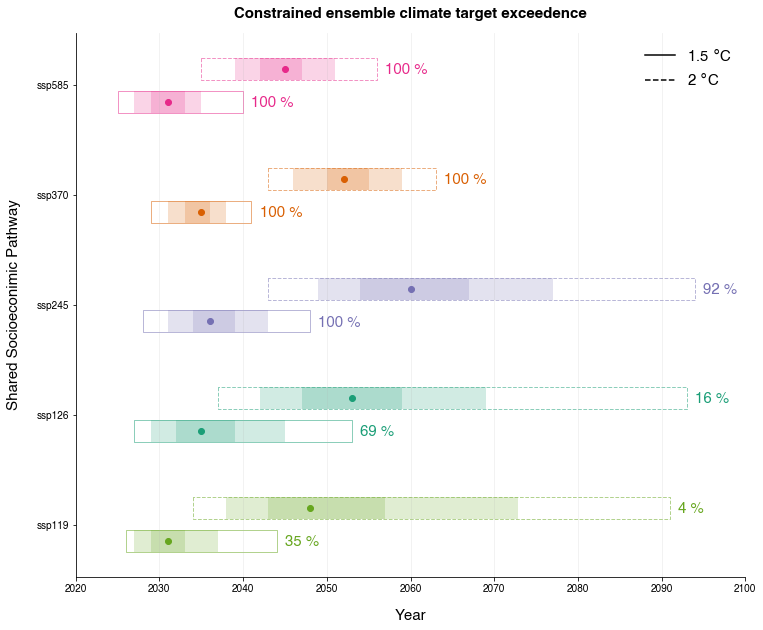

In [22]:
fig,ax = plt.subplots(1,figsize=(12,10))

for i,ssp in enumerate(scenarios):
    
    plt.plot(year_15_cross.loc[ssp].median(),i+0.1,'o',color=colors[ssp])
    
    for pctile in [0.3333,0.166666]:
        plt.fill_between(year_15_cross.loc[ssp].quantile([pctile,1-pctile]).values,[i,i],[i+0.2,i+0.2],'o',color=colors[ssp],alpha=0.2,lw=0)
        
    plt.fill_between(year_15_cross.loc[ssp].quantile([0.05,1-0.05]).values,[i,i],[i+0.2,i+0.2],'o',color=colors[ssp],fc='none',lw=1,alpha=0.5)
    
    plt.gca().text(year_15_cross.loc[ssp].quantile(0.95)+1,i+0.09,str(round(100-100*year_15_cross.loc[ssp].isna().sum()/year_15_cross.loc[ssp].size))+' %',ha='left',va='center',color=colors[ssp],fontsize=15)
    
    plt.plot(year_2_cross.loc[ssp].median(),i+0.4,'o',color=colors[ssp])
    
    for pctile in [0.3333,0.166666]:
        plt.fill_between(year_2_cross.loc[ssp].quantile([pctile,1-pctile]).values,[i+0.3,i+0.3],[i+0.5,i+0.5],'o',color=colors[ssp],alpha=0.2,lw=0)
        
    plt.fill_between(year_2_cross.loc[ssp].quantile([0.05,1-0.05]).values,[i+0.3,i+0.3],[i+0.5,i+0.5],'o',color=colors[ssp],fc='none',lw=1,alpha=0.5,ls='--')
    
    plt.gca().text(year_2_cross.loc[ssp].quantile(0.95)+1,i+0.39,str(round(100-100*year_2_cross.loc[ssp].isna().sum()/year_2_cross.loc[ssp].size))+' %',ha='left',va='center',color=colors[ssp],fontsize=15)

plt.plot([],[],'k',label='1.5 $\degree$C')
plt.plot([],[],'--k',label='2 $\degree$C')
    
plt.yticks(np.arange(5)+0.25,labels=scenarios)

plt.xticks(np.arange(2020,2101,10),labels=[str(x) for x in np.arange(2020,2101,10)])

[plt.gca().spines[pos].set_visible(False) for pos in ['right','top']]

plt.grid(axis='x',alpha=0.2)

plt.xlabel('Year',labelpad=15,fontsize=15)
plt.ylabel('Shared Socioeconimic Pathway',labelpad=15,fontsize=15)

plt.title('Constrained ensemble climate target exceedence',fontsize=15,fontweight='bold',pad=15)

plt.legend(fontsize=15)

[fig.savefig('../../../FaIR_v2-0_paper/Plots/CONSTRAINED_threshold_exceedence_year.'+x,bbox_inches='tight') for x in ['png','pdf']]

### correlations within 2.0 crossing members:

In [169]:
ssp119_results = pd.read_hdf('../Parameter_Sets/NROY_GWI_informed/SSP_results/ssp119_floating.h5')
FULL_results = pd.read_hdf('../Parameter_Sets/NROY_GWI_informed/FULL_results.h5')

In [178]:
ssp119_results.loc['anthro_2019',year_15_cross.loc['ssp119'].dropna().index].describe()

count    5373.000000
mean        2.529211
std         0.364842
min         1.163005
25%         2.284534
50%         2.522880
75%         2.774453
max         4.012768
Name: anthro_2019, dtype: float64

### the impact of the baseline temperature:

In [4]:
import statsmodels.api as sm
import xarray as xr
LOWESS = sm.nonparametric.lowess

In [6]:
baselines = {}
baselines['5-dataset_2010_2019'] = (GMST_datasets.loc['2010':'2019'].mean(axis=1).mean() - GMST_datasets.loc['1861':'1880'].mean(axis=1).mean())
baselines['HadCRUT5_2009_2018'] = HadCRUT5_analysis.loc[2009:2018].mean() - HadCRUT5_analysis.loc[1861:1880].mean()
baselines['SR151_2006_2015'] = 0.87 # relative to 1850-1900
baselines['SR152_2006_2015'] = 0.97 # relative to 1850-1900
baselines['PA_compatible'] = 0.6 # relative to 1850-1900

In [7]:
GMST_annual = (GMST_datasets.mean(axis=1) - GMST_datasets.loc['1861':'1880'].mean(axis=1).mean()).resample('y',loffset='-6m').mean()
GMST_annual.index = GMST_annual.index.year
GMST_annual_smooth = pd.Series(LOWESS(GMST_annual,GMST_annual.index,frac=0.1)[:,1],index=GMST_annual.index)

HadCRUT5_smooth = pd.Series(LOWESS(HadCRUT5_analysis-HadCRUT5_analysis.loc[1861:1880].mean(),HadCRUT5_analysis.index,frac=0.1)[:,1],index=HadCRUT5_analysis.index)

In [8]:
baselines['5-dataset_2019_LOWESS'] = GMST_annual_smooth.loc[2019]
baselines['HadCRUT5_2018_LOWESS'] = GMST_annual_smooth.loc[2018]

In [9]:
baselines

{'5-dataset_2010_2019': 0.9975975332553011,
 'HadCRUT5_2009_2018': 1.0428499999999998,
 'SR151_2006_2015': 0.87,
 'SR152_2006_2015': 0.97,
 'PA_compatible': 0.6,
 '5-dataset_2019_LOWESS': 1.1499611360979756,
 'HadCRUT5_2018_LOWESS': 1.1164903950531202}

In [38]:
alternate_baseline_results = pd.DataFrame(index=[0.05,0.17,0.333,0.5,0.666,0.83,0.95],columns=pd.MultiIndex.from_product([[1.5,2.0],baselines.keys()]))

for target in [1.5,2.0]:
    
    alternate_baseline_results.loc[:,(target,'5-dataset_2010_2019')] = ((temp_results_SSPs.loc[:,'ssp245'].rolling(11,center=True).mean() - temp_results_SSPs.loc[2010:2019,'ssp245'].mean() + baselines['5-dataset_2010_2019'])>target).idxmax().replace(1755,np.nan).replace(1750,np.nan).dropna().quantile([0.05,0.17,0.333,0.5,0.666,0.83,0.95])
    alternate_baseline_results.loc[:,(target,'HadCRUT5_2009_2018')] = ((temp_results_SSPs.loc[:,'ssp245'].rolling(11,center=True).mean() - temp_results_SSPs.loc[2009:2018,'ssp245'].mean() + baselines['HadCRUT5_2009_2018'])>target).idxmax().replace(1755,np.nan).replace(1750,np.nan).dropna().quantile([0.05,0.17,0.333,0.5,0.666,0.83,0.95])
    alternate_baseline_results.loc[:,(target,'SR151_2006_2015')] = ((temp_results_SSPs.loc[:,'ssp245'].rolling(11,center=True).mean() - temp_results_SSPs.loc[2006:2015,'ssp245'].mean() + baselines['SR151_2006_2015'])>target).idxmax().replace(1755,np.nan).replace(1750,np.nan).dropna().quantile([0.05,0.17,0.333,0.5,0.666,0.83,0.95])
    alternate_baseline_results.loc[:,(target,'SR152_2006_2015')] = ((temp_results_SSPs.loc[:,'ssp245'].rolling(11,center=True).mean() - temp_results_SSPs.loc[2006:2015,'ssp245'].mean() + baselines['SR152_2006_2015'])>target).idxmax().replace(1755,np.nan).replace(1750,np.nan).dropna().quantile([0.05,0.17,0.333,0.5,0.666,0.83,0.95])
    alternate_baseline_results.loc[:,(target,'5-dataset_2019_LOWESS')] = ((temp_results_SSPs.loc[:,'ssp245'].rolling(11,center=True).mean() - temp_results_SSPs.loc[2019,'ssp245'] + baselines['5-dataset_2019_LOWESS'])>target).idxmax().replace(1755,np.nan).replace(1750,np.nan).dropna().quantile([0.05,0.17,0.333,0.5,0.666,0.83,0.95])
    alternate_baseline_results.loc[:,(target,'HadCRUT5_2018_LOWESS')] = ((temp_results_SSPs.loc[:,'ssp245'].rolling(11,center=True).mean() - temp_results_SSPs.loc[2018,'ssp245'] + baselines['HadCRUT5_2018_LOWESS'])>target).idxmax().replace(1755,np.nan).replace(1750,np.nan).dropna().quantile([0.05,0.17,0.333,0.5,0.666,0.83,0.95])
    alternate_baseline_results.loc[:,(target,'PA_compatible')] = ((temp_results_SSPs.loc[:,'ssp245'].rolling(11,center=True).mean() - temp_results_SSPs.loc[1986:2005,'ssp245'].mean() + baselines['PA_compatible'])>target).idxmax().replace(1755,np.nan).replace(1750,np.nan).dropna().quantile([0.05,0.17,0.333,0.5,0.666,0.83,0.95])

In [40]:
alternate_baseline_results

1.5                                                     \
      5-dataset_2010_2019 HadCRUT5_2009_2018 SR151_2006_2015 SR152_2006_2015   
0.050                2028               2026            2028            2025   
0.170                2031               2028            2031            2028   
0.333                2034               2031            2034            2030   
0.500                2036               2033            2037            2033   
0.666                2039               2035            2040            2035   
0.830                2043               2038            2045            2039   
0.950                2048               2043            2052            2044   

                                                                \
      PA_compatible 5-dataset_2019_LOWESS HadCRUT5_2018_LOWESS   
0.050          2022                  2029                 2029   
0.170          2026                  2031                 2031   
0.333          2029                  2033                 2033   
0.500          2033                  2035                 2035   
0.666          2037                  2037                 2037   
0.830          2042                  2039                 2040   
0.950          2050                  2043                 2044   

                      2.0                                                     \
      5-dataset_2010_2019 HadCRUT5_2009_2018 SR151_2006_2015 SR152_2006_2015   
0.050                2043               2041            2043            2040   
0.170                2049               2046            2049            2046   
0.333                2054               2051            2055            2051   
0.500                2060               2056            2061            2056   
0.666                2067               2063            2068            2062   
0.830                2077               2072            2079            2072   
0.950                2094               2089            2098            2089   

                                                                
      PA_compatible 5-dataset_2019_LOWESS HadCRUT5_2018_LOWESS  
0.050          2037                  2044                 2044  
0.170          2044                  2049                 2049  
0.333          2050                  2054                 2054  
0.500          2056                  2059                 2059  
0.666          2063                  2065                 2065  
0.830          2074                  2074                 2075  
0.950          2093                  2090                 2091

In [41]:
alternate_baseline_results.to_csv('../../../FaIR_projection_interactive/alternative_baseline_time_to_target.csv')

### Temperature projections for comparison

In [37]:
(temp_results_SSPs.loc[2081:2100].mean() - temp_results_SSPs.loc[1995:2014].mean()).groupby(level=0).quantile([0.05,0.166,0.5,0.833,0.95]).unstack()

,0.050,0.166,0.500,0.833,0.950
ssp119,0.097749,0.226675,0.477678,0.832033,1.168272
ssp126,0.363200,0.517553,0.815444,1.228989,1.612074
ssp245,1.060046,1.256812,1.633649,2.134113,2.582133
ssp370,1.854292,2.089803,2.501768,3.030757,3.473141
ssp585,2.339664,2.664187,3.261427,4.031953,4.675624


### Temperature rate computation for comparison

In [38]:
temp_rate_2021_40 = temp_results_SSPs.loc[2021:2040].apply(lambda x: sp.stats.linregress(np.arange(20),x).slope)
temp_rate_2000_19 = temp_results_SSPs.loc[2000:2019].apply(lambda x: sp.stats.linregress(np.arange(20),x).slope)

Text(0.5, 1.0, '2021-2040 warming rate relative to 2000-2019 / K decade$^{-1}$')

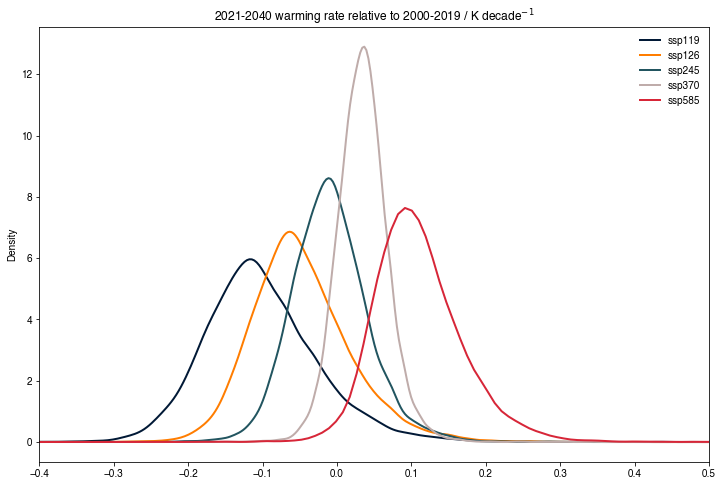

In [39]:
((temp_rate_2021_40-temp_rate_2000_19)*10).unstack().T.plot.kde(lw=2,figsize=(12,8))
plt.xlim(-0.4,0.5)
plt.title('2021-2040 warming rate relative to 2000-2019 / K decade$^{-1}$')

In [42]:
temp_rate_df = pd.concat([temp_results_SSPs.loc[2010:2014,'ssp245'].apply(lambda x: sp.stats.linregress(np.arange(5),x).slope),\
          temp_results_SSPs.loc[2014,'ssp245'].mean()-temp_results_SSPs.loc[1861:1880,'ssp245'].mean()],axis=1,keys=['rate','temp'])

#.describe(percentiles=[0.05,0.166,0.333,0.5,0.666,0.8333,0.95])

In [43]:
temp_rate_df.describe(percentiles=[0.05,0.166,0.333,0.5,0.666,0.8333,0.95])

,rate,temp
count,15304.000000,15304.000000
mean,0.030041,1.073482
std,0.005022,0.047159
min,0.014724,-0.162354
5%,0.022463,1.012550
16.6%,0.025173,1.036769
33.3%,0.027600,1.055859
50%,0.029729,1.069971
66.6%,0.031909,1.085684
83.3%,0.034807,1.108500
